## 0) Import Libraries and General Script

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import cobra
#from cobra.io import load_model
import pandas as pd
from tqdm import tqdm

# Parameters (Feeding point)
x_feed, y_feed, z_feed = 1.15, 10.24, 0.15     #m

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

# Define seaborn theme
sns.set_theme()
sns.set_context('paper')
# Set the Seaborn color palette
sns.set_palette("colorblind")

# Define scientific formatter in matplotlib
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
formatter.format = '%.1e'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

# dFBA - CFD Lifeline
## 1) Introduction
This jupyter notebook shows how it is possible to combine data coming from CFD simulations with metabolic modeling, specifically dFBA (Dynamic Flux Balance Analysis).

### 1.1) Cell-Lifelines 
First we have to solve the **general micro-balances** for momentum and mass using Computational Fluid Dynamics (Fluent):

$$
\begin{aligned}
&\text{Continuity Equation:}\quad\nabla\cdot\rho U + \frac{\partial \rho}{\partial t} = 0 \\
&\text{Navier-Stokes:}\quad\frac{\partial}{\partial t}\left(\rho U\right)+\nabla\cdot\left(\rho U \otimes U\right) = - \nabla P + \mu \nabla^2+\frac{1}{3}\mu\nabla\left(\nabla\cdot U\right) + \rho g \\
&\text{Mass Balance:}\quad\frac{\partial C_i}{\partial t} + \left(U \cdot \nabla\right)C_i = \mathcal{D}\nabla^2 C_i + r_i
\end{aligned}
$$

**Eulerian Specification of Fluid Flow:**

Field is represented as function of position $x$ and time $t$. **Flow velocity** is represented by the function:
$$
u\left(x,t\right)
$$

**Lagrangian Specification of Fluid Flow:**

Individual **fluid parcels** are followed through time. The fluid parcels (**cells** in our case) are labeled by some (time-independent) vector field $x_0$ (position of the center of mass of parcels at time $t_0$). In the Lagrangian description, the flow is described by a function:
$$
X(x_0,t)
$$
The two specifications are related as follows:
$$
u\left(X\left(x_0,t\right),t\right) = \frac{\partial X}{\partial t}\left(x_0, t\right)
$$
Because both sides describe the velocity of the particle labeled $x_0$ at time $t$.

The **important assumptions** to track **cell lifelines** are:
* Parcels have same density as the broth.
* Parcels have same velocity as fluid flows.
* No boundary layer around the cell.

Load data from the lifelines and plot environment seen by the cell

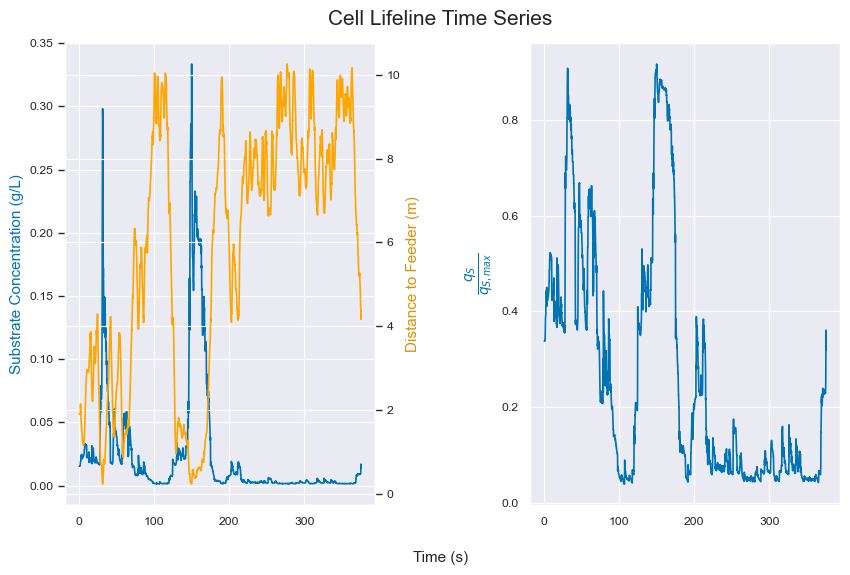

In [2]:
# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=time_array, y=C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11,
              color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=time_array, y=dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
              color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point
q_S= q_S_max*C_S_array/(K_S+C_S_array)
qS_qSmax = q_S/q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

#plt.title("Cell Lifeline Time Series", fontsize=14)
sns.lineplot(x=time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14,
                color=sns.color_palette()[0])
#ax2 = ax[1].twinx()
#sns.lineplot(x=time, y=dist_feed_point, color='orange', ax=ax2)
#ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
#              color=sns.color_palette()[1])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


### 1.2) dFBA


In [11]:
import cobra
from cobra.io import load_model
import numpy as np

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

def lexicographic_dFBA(C_S: float, model=load_model("textbook")):
    # Re-build model
    model = load_model("textbook")
    
    # Change solver --> When we have cplex cplex, by now glpk
    model.solver = 'glpk'
    
    # Add glucose import as a constraint wih monod
    glucose_max_import = - q_S_max * C_S / (K_S + C_S)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    
    # 1) Optimize aux-LP to get only feasible solutions
    cobra.util.solver.add_lp_feasibility(model)
    error = model.slim_optimize()
    # Establish feasibility objective as constraint
    cobra.util.fix_objective_as_constraint(model)
    
    # 2) Optimize the Biomass --> Import glucose in Lexicographic form and optimize for qS
    lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                    ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'min'])
    
    # 3) Solve model and compute fluxes
    solution = model.optimize()
    fluxes = np.array(model.optimize().fluxes.tolist())
    
    return model, solution, error
    

Solve dFBA with C_S from the lifelines

In [7]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=time_array,)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0,len(time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as csv file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)


100%|██████████| 3756/3756 [29:36<00:00,  2.11it/s]


## Training on multiple lifelines - UPDATED JAN 9

In [3]:
import os
import pandas as pd
import numpy as np

folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 375 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_6776\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_6776\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_6776\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_t

Shape of the Big Matrix: (376, 14, 48)


In [4]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Original shape of data_3d is (3754, 14, 48)

# Reorder and reshape the data to fit the [batch, timesteps, features] format
adjusted_data = np.transpose(data_3d, axes=(1, 0, 2))  # This will change the shape to (14, 3754, 48)

# Now, each of the 14 sequences (lifelines) is treated as a separate sample
print("Shape of the Adjusted Matrix:", adjusted_data.shape)

# Assuming `adjusted_data` is your original data with shape (376, 14, 48)
scaler = TimeSeriesScalerMinMax(value_range=(0, 1))

# Apply the scaler to your data
# Note that tslearn expects a three-dimensional array of shape (n_samples, n_timesteps, n_features)
# so make sure `adjusted_data` is in the correct shape
scaled_data = scaler.fit_transform(adjusted_data)
print(scaled_data)

Shape of the Adjusted Matrix: (14, 376, 48)
[[[1.01692541e-01 1.01692541e-01 1.14402053e-01 ... 1.59324690e-01
   3.00040952e-02 2.62578959e-15]
  [1.09972035e-01 1.09972035e-01 1.19498728e-01 ... 1.57856230e-01
   3.89443251e-02 6.56447399e-16]
  [1.90451782e-01 1.90451782e-01 1.69040304e-01 ... 1.43582264e-01
   1.25846670e-01 3.93868439e-15]
  ...
  [5.10467467e-02 5.10467467e-02 6.73110284e-02 ... 4.21036256e-01
   1.21070281e-02 3.07217348e-01]
  [5.16238963e-02 5.16238963e-02 6.80720667e-02 ... 4.14490321e-01
   1.17922280e-02 2.99384543e-01]
  [5.41622084e-02 5.41622084e-02 7.14191242e-02 ... 3.85701206e-01
   1.04077323e-02 2.64935755e-01]]

 [[2.46320341e-01 2.46320341e-01 2.22774332e-01 ... 1.93341680e-01
   2.09761999e-01 8.20114069e-15]
  [3.45673518e-01 3.45673518e-01 2.96822984e-01 ... 1.67854578e-01
   3.13934448e-01 4.68636611e-15]
  [3.83137626e-01 3.83137626e-01 3.24745260e-01 ... 1.58243899e-01
   3.53215808e-01 1.05443237e-14]
  ...
  [1.81618242e-01 1.81618242e-01 

Test without Hyperparameter Tuning

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# DataGenerator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=14, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Flattens the last two dimensions of the data, resulting in a shape of (14, 376 * 48)
merged_data = scaled_data.reshape(scaled_data.shape[0], -1)

# Reshapes the data to (14, 18048, 1)
original_data = merged_data.reshape(merged_data.shape[0], merged_data.shape[1], 1)

# Define the input layer needs to be 3D tensor of [batch, timesteps, feature]
inp = Input(shape=(original_data.shape[1], original_data.shape[2]))

# Encoder layers
encoder_lstm = LSTM(150, activation='tanh', return_sequences=False, kernel_initializer='glorot_uniform')
encoder = encoder_lstm(inp)
encoder_model = Model(inputs=inp, outputs=encoder)
encoder_model.summary()

latent = Dense(80, activation='tanh')(encoder)
latent_model = Model(inputs=inp, outputs=latent)
latent_model.summary()

# Decoder layers
repeated_latent = RepeatVector(original_data.shape[1])(latent)
decoder_lstm1 = LSTM(150, activation='tanh', return_sequences=True)
decoder1 = decoder_lstm1(repeated_latent)
decoder_lstm2 = LSTM(original_data.shape[2], activation='linear', return_sequences=True)
output = decoder_lstm2(decoder1)
decoder_model = Model(inputs=inp, outputs=output)
decoder_model.summary()

# Create the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18048, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
Total params: 91200 (356.25 KB)
Trainable params: 91200 (356.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18048, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense

In [6]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

from sklearn.model_selection import train_test_split

# Split the lifelines into training and validation sets
train_indices, val_indices = train_test_split(np.arange(original_data.shape[0]), test_size=0.2, random_state=42)

# Extract the corresponding data for training and validation
train_data = original_data[train_indices]
val_data = original_data[val_indices]

# Now you can create
train_gen = DataGenerator(train_data, batch_size=14, shuffle=True)
val_gen = DataGenerator(val_data, batch_size=14, shuffle=False)  # typically, you don't need to shuffle validation data

# Fit the autoencoder using the generators
history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[reduce_lr, early_stop])

# After training, you can evaluate the model on the validation set
val_predictions = autoencoder.predict(val_gen)
reconstruction_loss = np.sqrt(np.mean(np.square(val_gen - val_predictions)))
print(f"Validation RMSE: {reconstruction_loss}")


Epoch 1/15
1/1 [==============================] - 198s 198s/step - loss: 0.2644 - val_loss: 0.2350 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - 251s 251s/step - loss: 0.2064 - val_loss: 0.1873 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - 263s 263s/step - loss: 0.1581 - val_loss: 0.1538 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - 273s 273s/step - loss: 0.1301 - val_loss: 0.1805 - lr: 0.0010
Epoch 5/15
1/1 [==============================] - 251s 251s/step - loss: 0.1679 - val_loss: 0.1614 - lr: 0.0010
Epoch 6/15
1/1 [==============================] - 167s 167s/step - loss: 0.1443 - val_loss: 0.1529 - lr: 0.0010
Epoch 7/15
1/1 [==============================] - 184s 184s/step - loss: 0.1304 - val_loss: 0.1574 - lr: 0.0010
Epoch 8/15
1/1 [==============================] - 187s 187s/step - loss: 0.1316 - val_loss: 0.1640 - lr: 0.0010
Epoch 9/15
1/1 [==============================] - 206s 206s/step - loss: 0.1366 - val_loss: 0.1677 - lr:

In [7]:
print("Encoder Model Summary:")
encoder_model.summary()

Encoder Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18048, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
Total params: 91200 (356.25 KB)
Trainable params: 91200 (356.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
print("\nLatent Space Model Summary:")
latent_model.summary()


Latent Space Model Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18048, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 80)                12080     
                                                                 
Total params: 103280 (403.44 KB)
Trainable params: 103280 (403.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
print("\nDecoder Model Summary:")
decoder_model.summary()


Decoder Model Summary:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18048, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 80)                12080     
                                                                 
 repeat_vector (RepeatVecto  (None, 18048, 80)         0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 18048, 150)        138600    
                                                                 
 lstm_2 (LSTM)               (None, 18048, 1)          608       
                                   

In [12]:
# Split the original_data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(original_data, test_size=0.2, random_state=42)

# Create an encoder model
encoder_model = Model(inputs=inp, outputs=latent)

# Predict the latent and reconstructed data for the test set
latent_test_data = encoder_model.predict(test_data)
reconstructed_test_data = autoencoder.predict(test_data)

1/1 [==============================] - 6s 6s/step


In [13]:
# Assuming 'original_data' is your input data shaped appropriately
latent_representations = encoder_model.predict(original_data)

# latent_representations now contains 14 separate 40-dimensional vectors,
# each corresponding to a lifeline.


1/1 [==============================] - 6s 6s/step


In [14]:
import pandas as pd

# Convert to DataFrame
latent_df = pd.DataFrame(latent_representations)

# Optionally, name your columns for clarity
latent_df.columns = [f"Feature_{i}" for i in range(latent_df.shape[1])]


In [15]:
# Define the file path and name
file_path = "latent_representations.xlsx"

# Save to Excel
latent_df.to_excel(file_path, index=False)  # Set index=False if you don't want the row indices in your file


1/1 [==============================] - 13s 13s/step


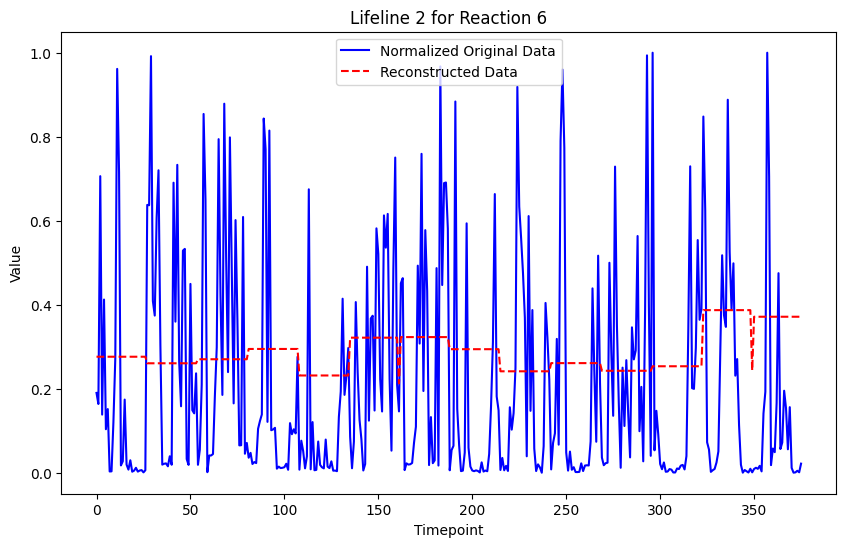

In [16]:
# Reshape original data back to its original 3D shape for plotting
# Assuming the original shape was (376, 14, 48)
original_data_3d = original_data.reshape(376, 14, 48)
reconstructed_data = autoencoder.predict(original_data)
reconstructed_data_3d = reconstructed_data.reshape(376, 14, 48)

# Choose a specific lifeline and reaction for plotting
lifeline_index = 2  # Example index
reaction_index = 6  # Example index

# Extract series for plotting
normalized_original_series = original_data_3d[:, lifeline_index, reaction_index]
reconstructed_series = reconstructed_data_3d[:, lifeline_index, reaction_index]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(normalized_original_series, label='Normalized Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f"Lifeline {lifeline_index} for Reaction {reaction_index}")
plt.xlabel('Timepoint')
plt.ylabel('Value')
plt.legend()
plt.show()


In [19]:
# Assuming the necessary imports and DataGenerator class definition are already done

# Assuming 'scaled_data' is the scaled version of 'data_3d' with shape (376, 14, 48)
# Flattens the last two dimensions of the data, resulting in a shape of (14, 376 * 48)
merged_data = scaled_data.reshape(scaled_data.shape[0], -1)

# Reshapes the data to (14, 18048, 1)
original_data = merged_data.reshape(merged_data.shape[0], merged_data.shape[1], 1)

# ... [your existing autoencoder architecture and training code] ...

# Predict the reconstructed data using the trained autoencoder
reconstructed_data = autoencoder.predict(original_data)

# Reshape the reconstructed data to match the original data's shape
reconstructed_data_3d = reconstructed_data.reshape(scaled_data.shape)

# Initialize the MinMaxScaler with the same range used during preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))

# Assuming 'data_3d' is the original unscaled data with shape (376, 14, 48)
# Flatten the original data to fit the scaler
data_flattened = data_3d.reshape(-1, data_3d.shape[2])

# Fit the scaler on the flattened original data and transform it
scaler.fit(data_flattened)
normalized_data_flattened = scaler.transform(data_flattened)

# Flatten the reconstructed data to the shape the scaler expects
reconstructed_data_flattened = reconstructed_data_3d.reshape(-1, data_3d.shape[2])

# Inverse transform the flattened reconstructed data
inverse_reconstructed_data_flattened = scaler.inverse_transform(reconstructed_data_flattened)

# Reshape the inverse transformed data back to its original 3D shape
inverse_reconstructed_data_3d


1/1 [==============================] - 12s 12s/step


NameError: name 'inverse_reconstructed_data_3d' is not defined

# Multiple Lifelines Testing with Hyperparameter Tuning

In [26]:
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

def objective(trial, data):
    # Hyperparameters
    hidden_units = trial.suggest_int('hidden_units', 10, 120)
    latent_units = trial.suggest_int('latent_units', 5, 40)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Model Definition
    inp = Input(shape=(data.shape[1], data.shape[2]))
    encoder = LSTM(hidden_units, activation=activation, return_sequences=False)(inp)
    latent = Dense(latent_units, activation=activation)(encoder)
    repeated_latent = RepeatVector(data.shape[1])(latent)
    decoder = LSTM(hidden_units, activation=activation, return_sequences=True)(repeated_latent)
    output = LSTM(data.shape[2], activation='linear', return_sequences=True)(decoder)
    autoencoder = Model(inputs=inp, outputs=output)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    # TimeSeriesSplit and Callbacks
    tscv = TimeSeriesSplit(n_splits=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    rmse = []

    for train_index, val_index in tscv.split(data):
        train, val = data[train_index], data[val_index]
        train_gen = DataGenerator(train, batch_size=32, shuffle=True)
        val_gen = DataGenerator(val, batch_size=32)
        history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[reduce_lr, early_stop])
        reconstruction_loss = np.sqrt(np.mean(np.square(val - autoencoder.predict(val_gen))))
        rmse.append(reconstruction_loss)

    return np.mean(rmse)

scaler = StandardScaler()

# Normalize each feature separately
for i in range(data_3d.shape[1]):
    data_3d[:, i, :] = scaler.fit_transform(data_3d[:, i, :])

merged_data = data_3d.reshape(data_3d.shape[0], -1)
original_data = merged_data.reshape(merged_data.shape[0], merged_data.shape[1], 1)


In [27]:
# Now use the objective function
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, original_data), n_trials=2)


[I 2023-11-24 18:00:42,740] A new study created in memory with name: no-name-e802d106-18b1-4199-bac7-16f932b19573


Epoch 1/30
20/20 [==============================] - 46s 2s/step - loss: 1.0598 - val_loss: 1.1539 - lr: 5.0385e-05
Epoch 2/30
20/20 [==============================] - 42s 2s/step - loss: 1.0597 - val_loss: 1.1538 - lr: 5.0385e-05
Epoch 3/30
20/20 [==============================] - 42s 2s/step - loss: 1.0596 - val_loss: 1.1538 - lr: 5.0385e-05
Epoch 4/30
20/20 [==============================] - 41s 2s/step - loss: 1.0595 - val_loss: 1.1538 - lr: 5.0385e-05
Epoch 5/30
20/20 [==============================] - 40s 2s/step - loss: 1.0594 - val_loss: 1.1537 - lr: 5.0385e-05
Epoch 6/30
20/20 [==============================] - 40s 2s/step - loss: 1.0592 - val_loss: 1.1537 - lr: 5.0385e-05
Epoch 7/30
20/20 [==============================] - 41s 2s/step - loss: 1.0590 - val_loss: 1.1536 - lr: 5.0385e-05
Epoch 8/30
20/20 [==============================] - 42s 2s/step - loss: 1.0587 - val_loss: 1.1535 - lr: 5.0385e-05
Epoch 9/30
20/20 [==============================] - 43s 2s/step - loss: 1.0582 -

[W 2023-11-24 18:16:55,215] Trial 0 failed with parameters: {'hidden_units': 96, 'latent_units': 24, 'activation': 'tanh', 'learning_rate': 5.038488833102446e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\elysi\AppData\Local\Temp\ipykernel_28976\1407536605.py", line 3, in <lambda>
    study.optimize(lambda trial: objective(trial, original_data), n_trials=2)
  File "C:\Users\elysi\AppData\Local\Temp\ipykernel_28976\408681530.py", line 60, in objective
    history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[reduce_lr, early_stop])
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\elysi\AppDa

KeyboardInterrupt: 

In [7]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'hidden_units': 17, 'latent_units': 34, 'activation': 'tanh', 'learning_rate': 0.0027572975779302763}
Best Loss: 0.9821244168898637


In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, Reshape

# Get the best hyperparameters from Optuna
best_params = study.best_params
hidden_units = best_params['hidden_units']
latent_units = best_params['latent_units']
activation = best_params['activation']

# Reshape the data for the autoencoder
reshaped_data = original_data

# Define the input layer
inp = Input(shape=(reshaped_data.shape[1], reshaped_data.shape[2]))

# Reshape the input to match desired dimensions
reshaped_input = Reshape((reshaped_data.shape[1] * reshaped_data.shape[2],))(inp)

# Encoder layers
encoder = Dense(hidden_units, activation=activation)(reshaped_input)
latent = Dense(latent_units, activation=activation)(encoder)

# Decoder layers
decoder = Dense(hidden_units, activation=activation)(latent)
output = Dense(reshaped_data.shape[1] * reshaped_data.shape[2], activation='linear')(decoder)

# Reshape the output to match original dimensions
reshaped_output = Reshape((reshaped_data.shape[1], reshaped_data.shape[2]))(output)

# Create the autoencoder model with best hyperparameters
autoencoder = Model(inputs=inp, outputs=reshaped_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with best hyperparameters
autoencoder.fit(reshaped_data, reshaped_data, epochs=20, batch_size=32)

# Get the reconstructed data
reconstructed_data = autoencoder.predict(reshaped_data)

# Reshape the reconstructed data and original data for visualization
reconstructed_data = np.squeeze(reconstructed_data)
original_data = np.squeeze(reshaped_data)


Epoch 1/20
118/118 [==============================] - 1s 4ms/step - loss: 0.7328
Epoch 2/20
118/118 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 3/20
118/118 [==============================] - 0s 2ms/step - loss: 0.3475
Epoch 4/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2909
Epoch 5/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2518
Epoch 6/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2230
Epoch 7/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2024
Epoch 8/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 9/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1687
Epoch 10/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 11/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 12/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1372
Epoch 13/20
118/118 [====

118/118 [==============================] - 0s 1ms/step


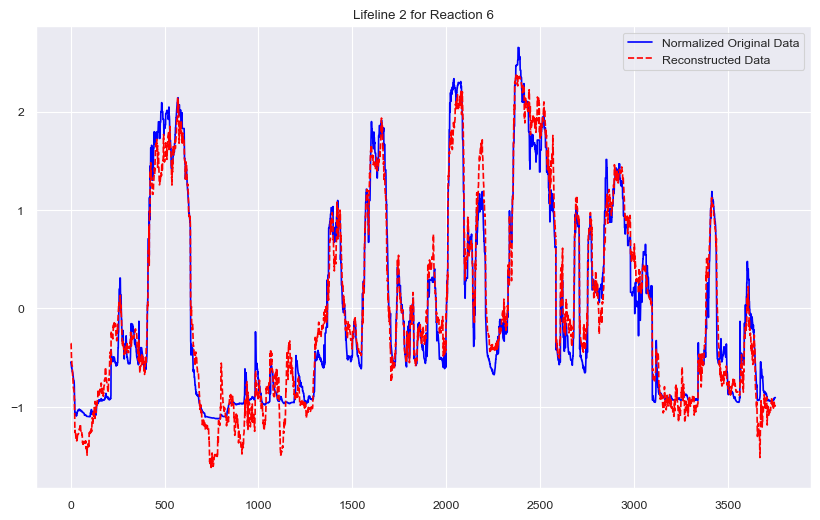

In [9]:
import matplotlib.pyplot as plt

original_data_reshaped = original_data.reshape(original_data.shape[0], original_data.shape[1], 1)
reconstructed_data_2d = autoencoder.predict(original_data_reshaped)

# Reshape reconstructed data back to the original 3D shape
reconstructed_data_3d = reconstructed_data_2d.reshape(data_3d.shape[0], data_3d.shape[1], data_3d.shape[2])

# Extract series for a specific lifeline and reaction
lifeline_index = 2
reaction_index = 6

# Normalized original series
normalized_original_series = data_3d[:, lifeline_index, reaction_index]

# Reconstructed series
reconstructed_series = reconstructed_data_3d[:, lifeline_index, reaction_index]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_original_series, label='Normalized Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f"Lifeline {lifeline_index} for Reaction {reaction_index}")
plt.legend()
plt.show()


In [11]:
import pandas as pd

# Convert the latent data to a DataFrame
latent_df = pd.DataFrame(latent_data)

# Save to a CSV file
latent_df.to_csv("latent_data_14lifelines.csv", index=False)


In [ ]:
# Save the entire model to a file
autoencoder.save('path_to_14lifeline_autoencoder.h5')  # The .h5 extension indicates a HDF5 file

In [1]:
# Step 1: Create the encoder model
encoder_model = Model(inputs=inp, outputs=latent)

# Step 2: Get the weights of the first layer of the encoder
# (assuming 'encoder' is the first layer of your encoder)
encoder_weights = encoder_model.layers[1].get_weights()[0]

# Step 3: Analyze the weights
# You can use various methods to analyze these weights.
# For example, you can look at the absolute values to see which original features
# contribute most to each latent feature.

# Printing the shape of the weights for understanding
print("Shape of encoder weights:", encoder_weights.shape)

# If you want to visualize the weights for each latent feature
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a list of names for your original features
feature_names = ['Feature1', 'Feature2', 'Feature3', ...]  # Replace with your actual feature names

for i in range(latent_units):  # Loop over each latent feature
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=encoder_weights[:, i])
    plt.title(f'Feature Contributions to Latent Feature {i}')
    plt.xticks(rotation=45)
    plt.show()


NameError: name 'Model' is not defined